In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from decision_tree import DecisionTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Testing the implementation of a decision tree for classification

## Loading the data

In [2]:
df = pd.read_csv("magic04.data", header=None)
print(f"Shape : {df.shape}")
print(f"Preview : ")
df.head()

Shape : (19020, 11)
Preview : 


,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


## Preparing the data

In [3]:
data = df.to_numpy()
x = data[:,:-1]
y = data[:,-1]

In [4]:
seed = 666

x_train, x_vt, y_train, y_vt = train_test_split(x, y, shuffle=True, random_state=seed)
x_val, x_test, y_val, y_test = train_test_split(x_vt, y_vt, random_state=seed)

## Comparing implementations (vs Scikit Learn)

### Accuracy 

In [5]:
# Our implementation with entropy as impurity mesurement
dt_entropy = DecisionTree()
dt_entropy.fit(x, y)

# Our implementation with gini as impurity mesurement
dt_gini = DecisionTree("gini")
dt_gini.fit(x_train, y_train)

# sklearn implementation (entropy)
sk_entropy = DecisionTreeClassifier(criterion="entropy")
sk_entropy.fit(x_train, y_train)
sk_entropy.cost_complexity_pruning_path(x_train, y_train)

# sklearn implementation (gini)
sk_gini = DecisionTreeClassifier(criterion="gini")
_ = sk_gini.fit(x_train, y_train)
#_ = sk_gini.cost_complexity_pruning_path(x_train, y_train)

In [6]:
pred = dt_entropy(x_val)
acc_dt_entropy = accuracy_score(y_val, pred)
pred = dt_gini(x_val)
acc_dt_gini = accuracy_score(y_val, pred)
pred = sk_entropy.predict(x_val)
acc_sk_entropy = accuracy_score(y_val, pred)
pred = sk_gini.predict(x_val)
acc_sk_gini = accuracy_score(y_val, pred)

accuracies = pd.DataFrame({
    "scikit learn" : {
        "gini": acc_sk_gini,
        "entropy": acc_sk_entropy
    },
    "our implmentation" : {
        "gini": acc_dt_gini,
        "entropy": acc_dt_entropy
    }
})

print("The accuracy of the different implmentations : ")
display(accuracies)

The accuracy of the different implmentations : 


,scikit learn,our implmentation
gini,0.809310,0.830342
entropy,0.803421,0.868200


### Speed comparaisons

#### Training

In [7]:
from time import time

sizes = [100, 1000, 5000, 10000, 50000, 100000]

training_times = pd.DataFrame({
    "size": {},
    "sklearn gini" : {},
    "sklearn entropy" : {},
    "ours gini" : {},
    "ours entropy" : {},
    "ours gini no pruning" : {},
    "ours entropy no pruning" : {}
})

inferance_times = pd.DataFrame({
    "size": {},
    "sklearn gini" : {},
    "sklearn entropy" : {},
    "ours gini" : {},
    "ours entropy" : {},
    "ours gini no pruning" : {},
    "ours entropy no pruning" : {}
})


def time_function(f):
    timer = time()
    f()
    return time() - timer

def benchmark(label, x, y):
    dt_entropy = DecisionTree()
    dt_gini = DecisionTree("gini")
    sk_entropy = DecisionTreeClassifier(criterion="entropy")
    sk_gini = DecisionTreeClassifier(criterion="gini")

    dt_entropy_np = DecisionTree()
    dt_gini_np = DecisionTree("gini")

    dt_entropy_time = time_function(
        lambda: dt_entropy.fit(x, y)
    )

    dt_gini_time = time_function(
        lambda: dt_gini.fit(x, y)
    )

    dt_entropy_time_np = time_function(
        lambda: dt_entropy_np.fit(x, y, skip_pruning=True)
    )

    dt_gini_time_np = time_function(
        lambda: dt_gini_np.fit(x, y, skip_pruning=True)
    )

    sk_entropy_time = time_function(
        lambda: sk_entropy.fit(x, y)
    )

    sk_gini_time = time_function(
        lambda: sk_gini.fit(x, y)
    )

    training_time = pd.DataFrame({
        "size" : {label: len(y)},
        "sklearn gini" : {label: sk_gini_time},
        "sklearn entropy" : {label: sk_entropy_time},
        "ours gini" : {label: dt_gini_time},
        "ours entropy" : {label: dt_entropy_time},
        "ours gini no pruning" : {label: dt_gini_time_np},
        "ours entropy no pruning" : {label: dt_entropy_time_np}
    })    

    dt_entropy_time = time_function(
        lambda: dt_entropy.predict(x)
    )

    dt_gini_time = time_function(
        lambda: dt_gini.predict(x)
    )

    dt_entropy_time_np = time_function(
        lambda: dt_entropy_np.predict(x)
    )

    dt_gini_time_np = time_function(
        lambda: dt_gini_np.predict(x)
    )

    sk_entropy_time = time_function(
        lambda: sk_entropy.predict(x)
    )

    sk_gini_time = time_function(
        lambda: sk_gini.predict(x)
    )

    inferance_time = pd.DataFrame({
        "size" : {label: len(y)},
        "sklearn gini" : {label: sk_gini_time},
        "sklearn entropy" : {label: sk_entropy_time},
        "ours gini" : {label: dt_gini_time},
        "ours entropy" : {label: dt_entropy_time},
        "ours gini no pruning" : {label: dt_gini_time_np},
        "ours entropy no pruning" : {label: dt_entropy_time_np}
    })

    return training_time, inferance_time

for size in sizes:
    x = np.random.rand(size, 10)
    y = np.random.randint(0, 2, size=(size,))

    training_time, inferance_time = benchmark(f"Random({size})", x, y)

    training_times = pd.concat([
        training_times,
        training_time
    ])

    inferance_times = pd.concat([
        inferance_times,
        inferance_time        
    ])

training_time, inferance_time = benchmark(f"Real Dataset({len(y_train)})", x_train, y_train)

training_times = pd.concat([
    training_times,
    training_time
])

inferance_times = pd.concat([
    inferance_times,
    inferance_time        
])

print("Training duration of the implementation of the decision tree against the scikit-learn implementation : ")
display(training_times)
print("Inference duration of the implementation of the decision tree against the scikit-learn implementation : ")
display(inferance_times)

Training duration of the implementation of the decision tree against the scikit-learn implementation : 


,size,sklearn gini,sklearn entropy,ours gini,ours entropy,ours gini no pruning,ours entropy no pruning
Random(100),100.0,0.001036,0.001466,0.010558,0.010062,0.011136,0.009616
Random(1000),1000.0,0.012362,0.022110,0.089149,0.090959,0.101758,0.102946
Random(5000),5000.0,0.116144,0.181863,0.502847,0.519014,0.707987,0.624208
Random(10000),10000.0,0.298705,0.616014,0.978309,1.052456,1.124434,1.121355
Random(50000),50000.0,2.004840,3.215121,5.294120,5.350024,6.912607,6.571148
Random(100000),100000.0,6.264912,8.735814,10.700568,11.275897,13.926648,12.969424
Real Dataset(14265),14265.0,0.249070,0.260216,0.922623,1.159869,0.984642,1.064596


Inference duration of the implementation of the decision tree against the scikit-learn implementation : 


,size,sklearn gini,sklearn entropy,ours gini,ours entropy,ours gini no pruning,ours entropy no pruning
Random(100),100.0,0.000162,0.000222,0.000040,0.000076,0.000922,0.000625
Random(1000),1000.0,0.000310,0.000380,0.002823,0.002016,0.006318,0.007419
Random(5000),5000.0,0.000786,0.000999,0.007400,0.007980,0.033671,0.031817
Random(10000),10000.0,0.002009,0.002691,0.016850,0.014945,0.060588,0.059386
Random(50000),50000.0,0.014321,0.015427,0.088467,0.095884,0.337072,0.333064
Random(100000),100000.0,0.037038,0.047220,0.163824,0.179349,0.838695,0.603428
Real Dataset(14265),14265.0,0.012179,0.010289,0.048477,0.037320,0.092225,0.100787


Text(0.5, 1.0, 'Inference durations for the implementations of DecisionTreeClassifier (pruning diasbled)')

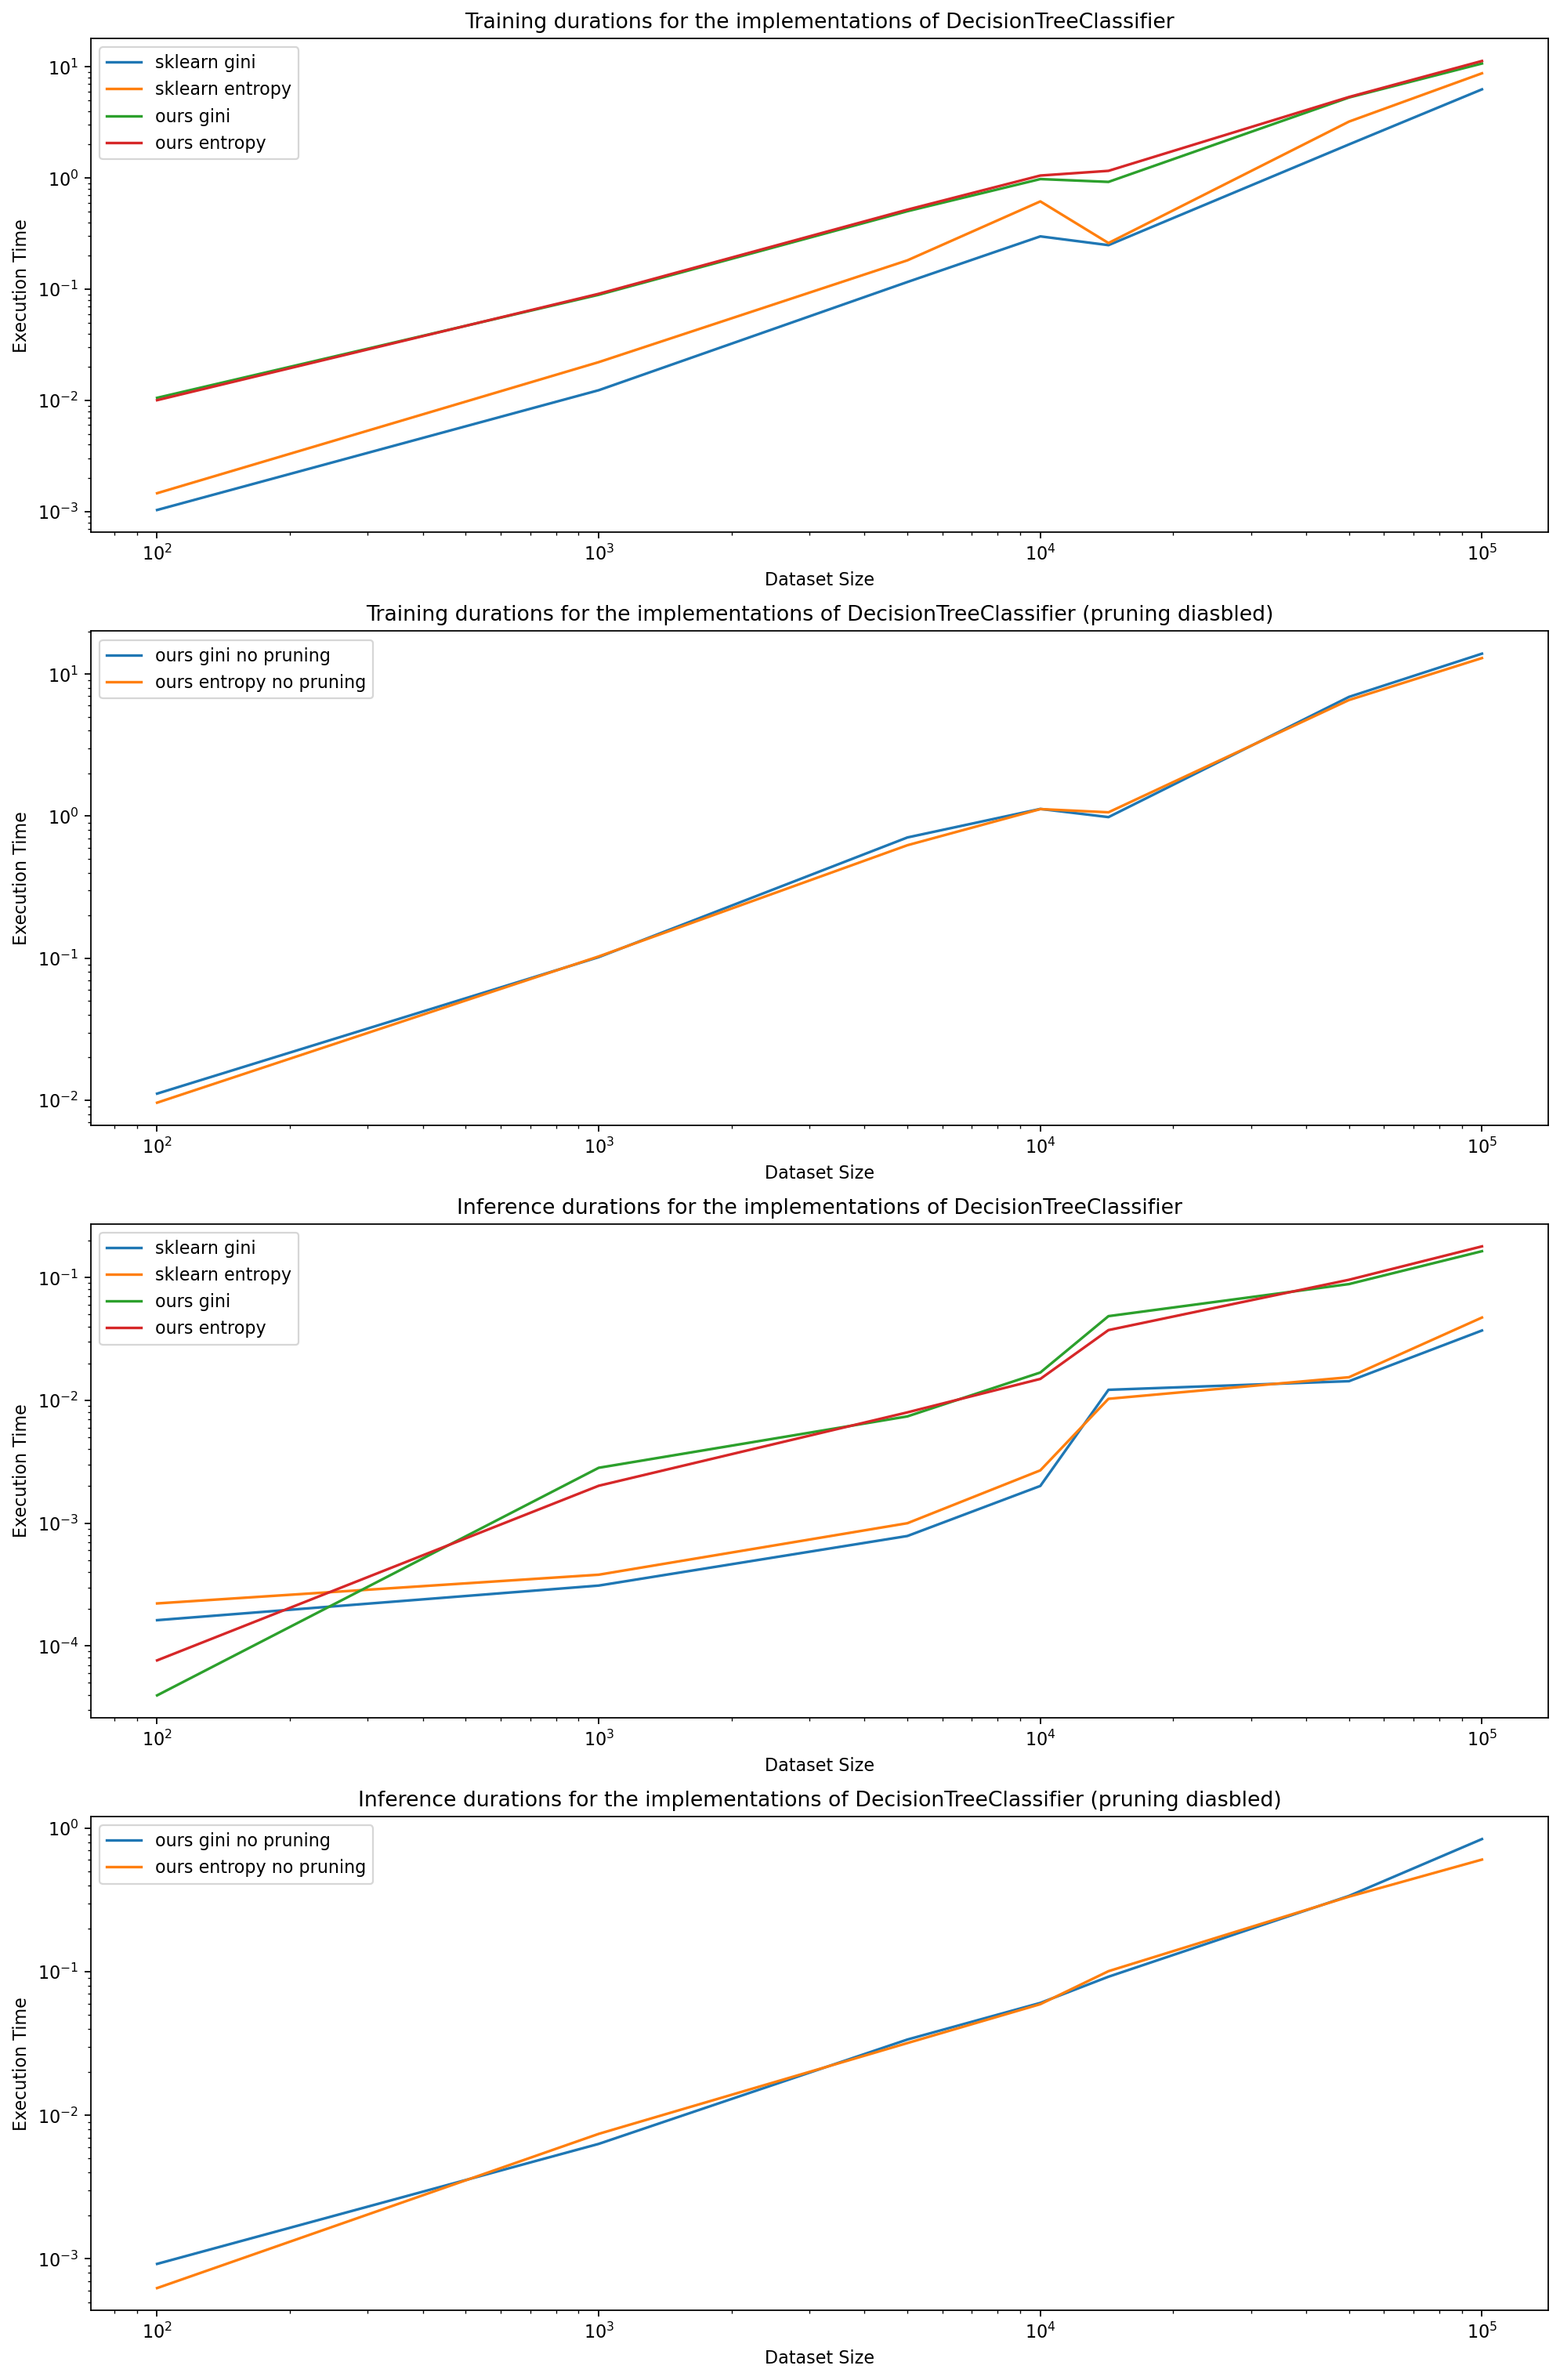

In [8]:
training_times = training_times.sort_values("size")
inferance_times = inferance_times.sort_values("size")

columns_p = [x for x in training_times.columns if x != "size" and "no pruning" not in x ]
columns_np = [x for x in training_times.columns if x != "size" and "no pruning" in x ]

fig, axs = plt.subplots(4, 1, figsize=(15, 24), dpi=160)



for column in columns_p:
    training_times.plot.line("size", column, ax=axs[0])
    inferance_times.plot.line("size", column, ax=axs[2])

for column in columns_np:
    training_times.plot.line("size", column, ax=axs[1])
    inferance_times.plot.line("size", column, ax=axs[3])

for ax in axs:
    ax.set_yscale("log")
    ax.set_ylabel("Execution Time")
    ax.set_xscale("log")
    ax.set_xlabel("Dataset Size")

axs[0].set_title("Training durations for the implementations of DecisionTreeClassifier")
axs[2].set_title("Inference durations for the implementations of DecisionTreeClassifier")
axs[1].set_title("Training durations for the implementations of DecisionTreeClassifier (pruning diasbled)")
axs[3].set_title("Inference durations for the implementations of DecisionTreeClassifier (pruning diasbled)")

## Testing the selected model

In [9]:
pred_test = dt_entropy(x_test)
test_acc = accuracy_score(y_test, pred_test)
print(f"The selected model achieved {test_acc} accuracy on the test set")

The selected model achieved 0.8738435660218671 accuracy on the test set
